# 04_tml_cv_baseline

We will use the train/test data generated from *00_create_dataset.ipynb* and use basic machine learning models to generate a baseline reference of model performance on our data. We will then decide on how to improve the various models after this

Following feedback from interim presentation, cross validation will be implemented. That is, we will import the train set, split it into train-val, and run all of our notebooks. Then evaluation on the test set will only be implemented on the selected top models

In [ ]:
''' data and math '''
import pandas as pd
import numpy as np

''' plotting images '''
from matplotlib import pyplot as plt
%matplotlib inline

''' traversing directories '''
import os
from pathlib import Path

''' utilities '''
from tqdm import tqdm

''' metrics '''
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

''' preprocessing '''
from sklearn.preprocessing import StandardScaler

In [ ]:
''' used to reference the root directory, for directory traversal ''' 
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
mount_dir = '/content/gdrive'
root_dir = Path('/content/gdrive/My Drive/it3011_project')

Mounted at /content/gdrive


# Loading data

In [ ]:
# load data
train = pd.read_csv(root_dir/"data/train_no_na.csv")
test = pd.read_csv(root_dir/"data/test_no_na.csv")
print("data loaded")

data loaded


In [ ]:
# check shape
print(train.shape)
print(test.shape)

(279331, 138)
(120163, 138)


In [ ]:
# create train/val/test sets
features = [feature for feature in test.keys() if "feature" in feature]
x_train = train.loc[:, features].values
y_train = train.loc[:,['action']].values.flatten()
x_test = test.loc[:, features].values
y_test = test.loc[:,['action']].values.flatten()
print("train/test set created")

train/test set created


# Helper functions

In [ ]:
# constants
SEED = 42

# cross validation
from sklearn.model_selection import KFold
kf = KFold(n_splits=10, random_state=SEED, shuffle=True)

In [ ]:
# create the utility score, which takes in the prediction value and the ground truth action and generates a score
# link: https://www.kaggle.com/c/jane-street-market-prediction/overview/evaluation

# data: original train/test data    action: the y-value. can either be y_pred or original values too, if we want the max score attainable
def utility_score(data, action): 
  dates_set = set(data.date.values)
  dates = data.loc[:, ['date']].values.flatten()
  weights = data.loc[:, ['weight']].values.flatten()
  resps = data.loc[:, ['resp']].values.flatten()
  actions = action.flatten()

  i = len(dates_set)
  p_i = []

  for date in dates_set:
    indices = np.where(dates == date)[0]
    p_i_temp = 0
    for j in indices:
      p_i_temp = p_i_temp + weights[j] * resps[j] * actions[j]
    p_i.append(p_i_temp)
  
  p_i_squared = [p_i1*p_i2 for p_i1,p_i2 in zip(p_i,p_i)]
  t = ( sum(p_i) / np.sqrt(sum(p_i_squared)) ) * np.sqrt(250/i)
  u = min(max(t, 0), 6) * sum(p_i)

  return u

def max_train_utility_score(data=train, action=y_train):
  return utility_score(data, action)

def max_test_utility_score(data=test, action=y_test):
  return utility_score(data, action)

In [ ]:
def model_scores(model, test, x_test, y_test):
  y_pred = model.predict(x_test) 
  
  # # get some scores from helpers
  utility = utility_score(test, y_pred)
  accuracy =  accuracy_score(y_test, y_pred)

  # # confusion matrix
  # print("confusion matrix")
  cm = confusion_matrix(y_test, y_pred)
  true_pos = cm[1][1]
  true_neg = cm[0][0]
  false_pos = cm[0][1]
  false_neg = cm[1][0]

  # # plot confusion matrix
  # fig, ax = plt.subplots(figsize=(3, 3))
  # ax.imshow(cm)
  # ax.grid(False)
  # ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
  # ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
  # ax.set_ylim(1.5, -0.5)
  # for i in range(2):
  #     for j in range(2):
  #         ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
  # plt.show()  

  # # AUC-ROC
  # print("AUC_ROC")
  logit_roc_auc = roc_auc_score(y_test, model.predict(x_test))

  # # plot auc-roc
  # fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(x_test)[:,1])
  # plt.figure()
  # plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
  # plt.plot([0, 1], [0, 1],'r--')
  # plt.xlim([0.0, 1.0])
  # plt.ylim([0.0, 1.05])
  # plt.xlabel('False Positive Rate')
  # plt.ylabel('True Positive Rate')
  # plt.title('Receiver operating characteristic')
  # plt.legend(loc="lower right")
  # plt.show()

  return utility, accuracy, logit_roc_auc, true_pos, true_neg, false_pos, false_neg

In [ ]:
import datetime
import csv

def save_scores(output_filename, workbook_name, model_name, model_params, utility, accuracy, logit_roc_auc, true_pos, true_neg, false_pos, false_neg):
  # create output file if not exists
  try:
    f = open(root_dir/output_filename)
  except IOError:
    with open (root_dir/output_filename, 'a') as csvfile:
      headers = ["workbook_name", "model_name", "model_params", "utility", "accuracy", "logit_roc_auc", "true_pos", "true_neg", "false_pos", "false_neg", "timestamp"]
      writer = csv.DictWriter(csvfile, delimiter=',', lineterminator='\n',fieldnames=headers)
      writer.writeheader() 
      print("created output file")  
    csvfile.close()

  # output file exists, append
  timestamp = datetime.datetime.now().strftime("%d/%m/%Y %H:%M:%S")
  
  ''' create another df that looks just like the excel file and concat with ''' 
  new_scores = pd.DataFrame(np.array([[workbook_name, model_name, model_params, utility, accuracy, logit_roc_auc, true_pos, true_neg, false_pos, false_neg, timestamp]]),
                   columns=["workbook_name", "model_name", "model_params", "utility", "accuracy", "logit_roc_auc", "true_pos", "true_neg", "false_pos", "false_neg", "timestamp"],
                  )

  new_scores.to_csv(root_dir/output_filename, mode='a', header=False, index=False)
  print("saved model metrics")

# Random Forest model

In [ ]:
# import model
from sklearn.ensemble import RandomForestClassifier

# settings to vary
n_estimators = [10,30,50]
max_depths = [2,4,8,16]
max_features = [None, 'sqrt', 'log2']

In [ ]:
# iterate over settings for the model
for n_estimator in n_estimators:
  for max_depth in max_depths:
    for max_feature in max_features:
      output_filename = "CV_SCORES_AVE_TML.csv"
      workbook_name = "04D_tml_cv_baseline_random_forest"
      model_name = "Random Forest model"
      model_params = f"n_estimators={n_estimator}, max_depth={max_depth}, max_feature={max_feature}"
      
      print("")
      print("model_name: ", model_name)
      print("model_params: ", model_params)
      
      # cross validation
      cv_scores = []

      for i, (train_idx, val_idx) in enumerate(kf.split(x_train)):
        # train-val data (for utility score calculation) 
        train_cv, val_cv = train.iloc[train_idx], train.iloc[val_idx]
        # train-val features 
        x_train_cv, x_val_cv, y_train_cv, y_val_cv = x_train[train_idx], x_train[val_idx], y_train[train_idx], y_train[val_idx]

        # scaling data to make it easier for models to train
        scaler = StandardScaler().fit(x_train_cv)
        x_train_cv = scaler.transform(x_train_cv)

        # test set scaled on the same scaler as train, because models are fitted on the train distributions and not test distributions
        x_val_cv = scaler.transform(x_val_cv)

        print(f"training model fold {i+1}")
        model = RandomForestClassifier(
          n_estimators=n_estimator, 
          max_depth=max_depth,
          max_features=max_feature
        )
        model.fit(x_train_cv, y_train_cv)
        model_score = model_scores(model, test=val_cv, x_test=x_val_cv, y_test=y_val_cv)
        cv_scores.append(model_score)
      
      # mean of cv scores
      cv_scores_ave = [sum(ele) / len(cv_scores) for ele in zip(*cv_scores)]
      print("cv_scores key: utility, accuracy, logit_roc_auc, true_pos, true_neg, false_pos, false_neg")
      print("cv_scores_ave: ", cv_scores_ave)

      # save average scores
      save_scores(output_filename, workbook_name, model_name, model_params, *cv_scores_ave)


model_name:  Random Forest model
model_params:  n_estimators=10, max_depth=16, max_feature=None
training model fold 1
training model fold 2
training model fold 3
training model fold 4
training model fold 5
training model fold 6
training model fold 7
training model fold 8
training model fold 9
training model fold 10
cv_scores key: utility, accuracy, logit_roc_auc, true_pos, true_neg, false_pos, false_neg
cv_scores_ave:  [1438.6997443240202, 0.6347773858409075, 0.6347914066833789, 9043.2, 8688.1, 4992.1, 5209.7]
saved model metrics


# Conclusion

Best performing hyperparameters: n_estimators=50, max_depth=16, max_feature=None
* Utility score: 1724.054002
* Accuracy: 0.66179904

It is observed that random forest with max_depth = 16 perform the best. Overall performance (utility score and accuracy) increases with max_depth.


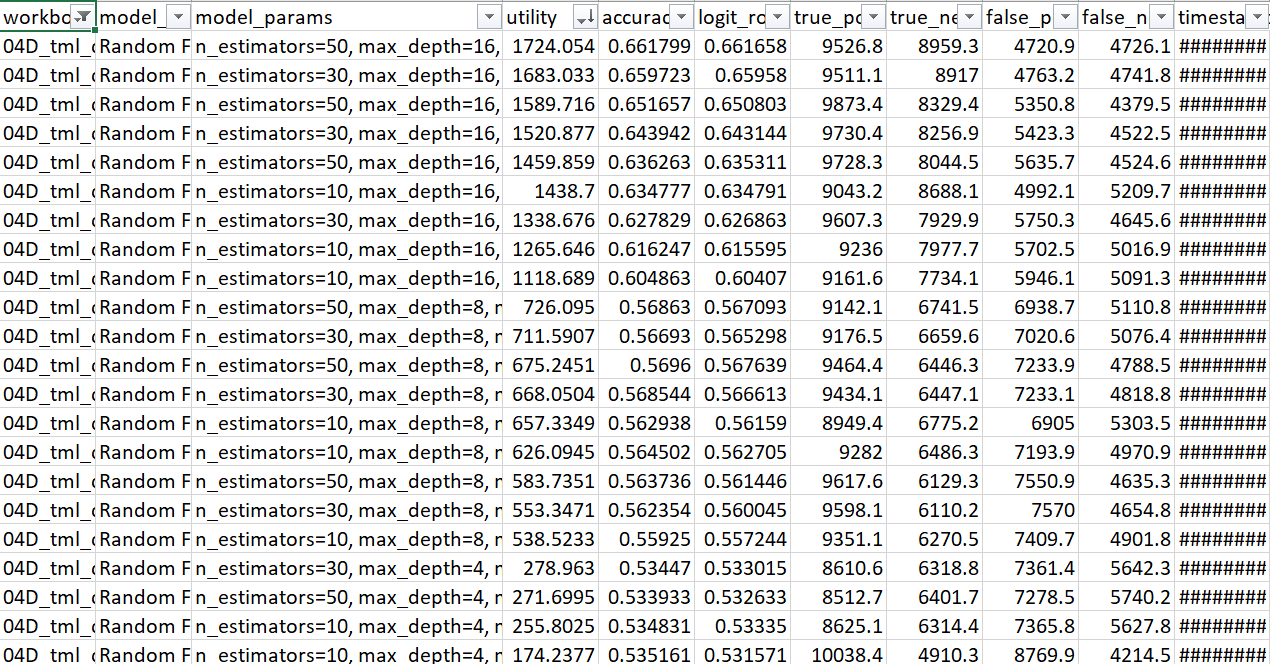



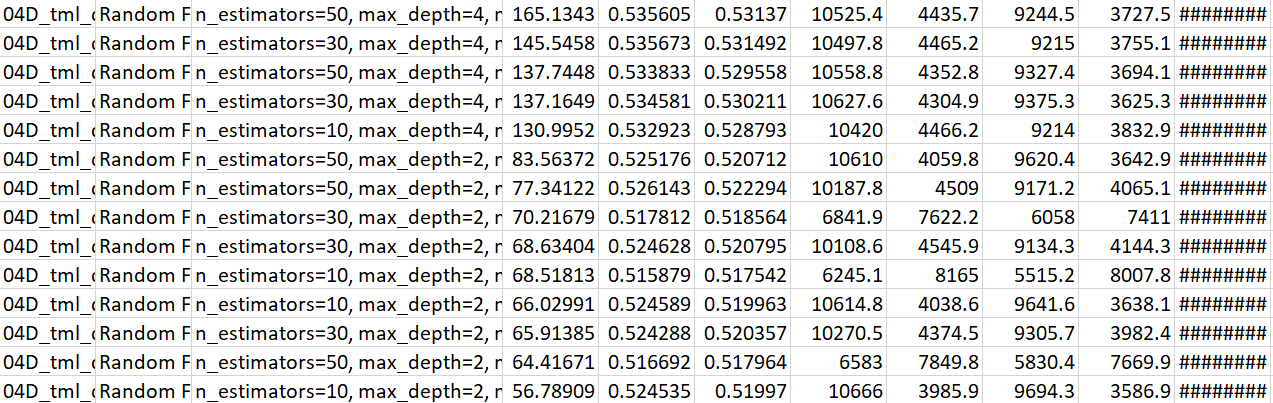